# Model tuning and comparison

In this notebook, we will investigate different models and transformers to see which one performs better and what are the best hyperparameters. <br>
<br>For estimator, we will use:
- Logistic Regression
- KNN 
- Naive Bayes

For transformers, the following approaches are used:
- `CountVectorizer`
- `TfidfVectorizer`

Our analysis in starts by using `CountVectorizer` as our initial transformer. Various models will be used on this data and upon finding the best performing model, we will use that model to test against `TfidfVectorizer` as well to see which one performs better. <br>

Additionally, we will build a hybrid model in which it uses both the text and word information along with the numerical features extracted from analyzing the text (word count and sentiment data). This is an effort to see whether using extra features or engineered features would help us achieve a better classification performance or not. <br>

At the end, we will evaluate the performance of ensemble based decision trees in our classification problem. In this case, we have used `CountVectorizer`


In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

import re 
from nltk.sentiment.vader import SentimentIntensityAnalyzer # for sentiment analyzer
#sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


## Data import and train/test split

Similar to the previous section, we will import the data and create train/test split.

In [14]:
# read the data from preprocessed data that are saved into files
df = pd.read_csv('./../dataset/offmychestrelationship_advice_processed.csv')
df.head(2)

,text,subreddit,word_count,sentiment
0,Sometimes I’m like oh wow can’t wait to marry ...,0,112,0.8560
1,\nMy girlfriend is bisexual. While I don’t hav...,1,620,0.9987


In [15]:
X = df[['text', 'word_count', 'sentiment']]
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42,
                                                    test_size=0.2,
                                                    stratify=y)
X_train = pd.DataFrame(X_train, columns=['text', 'word_count', 'sentiment'])
X_test = pd.DataFrame(X_test, columns=['text', 'word_count', 'sentiment'])

## Logistic Regression with CountVectorizer

For this section, we will use the model prepared from benchmarking notebook in which we optimized the Logistic Regression parameters with Gridseach and found the best performance. 

In [16]:
# create X train and test best on only the text column
Z_train = X_train['text']
Z_test = X_test['text']
# create a pipe instance 
pipe_cvec_logr = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegression())
])

# decide on what parameters to modify for transformer and estimator
params_cvec_logr = {
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1, 2)],
    'cvec__max_df': [1.0, 0.8, 0.5],
    'cvec__min_df': [2, 4],
    'cvec__max_features': [3000],
    'logr__C': [0.02, 0.05, 0.07, 0.1, 0.2],
    'logr__penalty': ['l2'], 
}

gs_cvec_logr = GridSearchCV(pipe_cvec_logr,
                 param_grid=params_cvec_logr,
                 n_jobs=-1,
                 cv=3,
                 verbose=2)

gs_cvec_logr.fit(Z_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [1.0, 0.8, 0.5],
                         'cvec__max_features': [3000], 'cvec__min_df': [2, 4],
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'logr__C': [0.02, 0.05, 0.07, 0.1, 0.2],
                         'logr__penalty': ['l2']},
             verbose=2)

In [17]:
print('============= LogReg =============')
print(f'best cv score: {gs_cvec_logr.best_score_}') # through cross-validation
print('=============')
print(f'best params:') # best parameters
[print(f'{ind}: {val}') for ind, val in gs_cvec_logr.best_params_.items()];
print('=============')
pred = gs_cvec_logr.predict(Z_test)

print(f'train score: {gs_cvec_logr.score(Z_train, y_train)}')
print(f'test score: {gs_cvec_logr.score(Z_test, y_test)}')

print('=============')
#pd.DataFrame(gs_cvec_logr.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)

============= LogReg =============
best cv score: 0.8803813038130381
best params:
cvec__max_df: 0.5
cvec__max_features: 3000
cvec__min_df: 2
cvec__ngram_range: (1, 2)
cvec__stop_words: english
logr__C: 0.07
logr__penalty: l2
train score: 0.9491851168511685
test score: 0.8834921610820781


## KNN with CountVectorizer

In this section, we will see how KNN will perform in classifying our data.

In [19]:
# create X train and test best on only the text column
Z_train = X_train['text']
Z_test = X_test['text']
# create a pipe instance 
pipe_cvec_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

# decide on what parameters to modify for transformer and estimator
params_cvec_knn = {
    'cvec__stop_words': [None] ,# 'english'],
    'cvec__ngram_range': [(1, 2)],
    'cvec__max_df': [0.95], # 0.8, 0.5],
#    'cvec__min_df': [2, 4],
    'cvec__max_features': [300, 500, 1000],
    'knn__n_neighbors': list(range(8, 25, 2))
}

gs_cvec_knn = GridSearchCV(pipe_cvec_knn,
                 param_grid=params_cvec_knn,
                 n_jobs=-1,
                 cv=3,
                 verbose=1)

gs_cvec_knn.fit(Z_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


c:\Users\masou\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan 0.77436962 0.77544588        nan 0.76253075        nan
        nan        nan        nan 0.76975707 0.76914207 0.77121771
 0.74784748 0.75353629        nan        nan 0.76360701        nan
 0.76629766        nan 0.76422202]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.95],
                         'cvec__max_features': [300, 500, 1000],
                         'cvec__ngram_range': [(1, 2)],
                         'cvec__stop_words': [None],
                         'knn__n_neighbors': [8, 10, 12, 14, 16, 18, 20, 22,
                                              24]},
             verbose=1)

In [20]:
print('============= KNN =============')
print(f'best cv score: {gs_cvec_knn.best_score_}') # through cross-validation
print('=============')
print(f'best params:') # best parameters
[print(f'{ind}: {val}') for ind, val in gs_cvec_knn.best_params_.items()];
print('=============')
pred = gs_cvec_knn.predict(Z_test)

print(f'train score: {gs_cvec_knn.score(Z_train, y_train)}')
print(f'test score: {gs_cvec_knn.score(Z_test, y_test)}')

print('=============')
pd.DataFrame(gs_cvec_knn.cv_results_).sort_values(by='mean_test_score', ascending=False).head(10)

============= KNN =============
best cv score: 0.7754458794587946
best params:
cvec__max_df: 0.95
cvec__max_features: 300
cvec__ngram_range: (1, 2)
cvec__stop_words: None
knn__n_neighbors: 24
train score: 0.7946648216482165
test score: 0.7777436212726714


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__ngram_range,param_cvec__stop_words,param_knn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,22.601203,0.481789,22.433740,1.171363,0.95,300,"(1, 2)",None,24,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.770756,0.782518,0.773063,0.775446,0.005089,1
7,20.426651,0.517186,23.454713,1.252792,0.95,300,"(1, 2)",None,22,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.768681,0.780673,0.773755,0.774370,0.004915,2
17,35.251082,2.103824,41.037591,1.120761,0.95,500,"(1, 2)",None,24,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.762915,0.778598,0.772140,0.771218,0.006436,3
15,28.194152,1.014803,29.102957,3.106597,0.95,500,"(1, 2)",None,20,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.762454,0.775830,0.770987,0.769757,0.005530,4
16,28.961356,1.188357,38.207479,2.649415,0.95,500,"(1, 2)",None,22,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.762454,0.776753,0.768220,0.769142,0.005874,5
24,34.085973,1.094185,35.682373,1.546781,0.95,1000,"(1, 2)",None,20,"{'cvec__max_df': 0.95, 'cvec__max_features': 1...",0.757149,0.773985,0.767758,0.766298,0.006950,6
26,28.665853,4.454135,16.143958,3.393197,0.95,1000,"(1, 2)",None,24,"{'cvec__max_df': 0.95, 'cvec__max_features': 1...",0.756227,0.770526,0.765913,0.764222,0.005959,7
22,29.857706,0.792714,38.198259,1.029127,0.95,1000,"(1, 2)",None,16,"{'cvec__max_df': 0.95, 'cvec__max_features': 1...",0.753459,0.769142,0.768220,0.763607,0.007185,8
10,24.521135,2.049888,21.400431,0.377896,0.95,500,"(1, 2)",None,10,"{'cvec__max_df': 0.95, 'cvec__max_features': 5...",0.755535,0.768450,0.763607,0.762531,0.005327,9
19,32.505357,2.888167,31.000571,0.581728,0.95,1000,"(1, 2)",None,10,"{'cvec__max_df': 0.95, 'cvec__max_features': 1...",0.746310,0.761531,0.752768,0.753536,0.006238,10


**Observation:**
- As expected, the KNN performs better when we use fewer number of features. In our case, we case reducing the max number of features to 300-500 would give us the best results. 
- Similar to what we observed with Logistic Regression, when we play with max features in the model, we can see that increasing the max feature does not help with the test/cv score and only helps with the train score, meaning that using features more that a threshold (here 300 to 500) will cause overfitting. 
- Gridsearch analysis shows that using `max_df` of 0.95 gives us the best results.
- Using stopewords are observed to deteriorate model performance so we decided to go with no stop words. 
- Using ngrams (1, 2) improves the scores slightly, so we decided to choose that.
- Best estimators are the ones that use `n_neghbors` in the rang of 10-20 (please see the below graph).


C:\Users\masou\AppData\Local\Temp\ipykernel_1756\1180272911.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results[results['mean_test_score'].notnull()].groupby('param_knn__n_neighbors').mean()['mean_test_score'].plot()


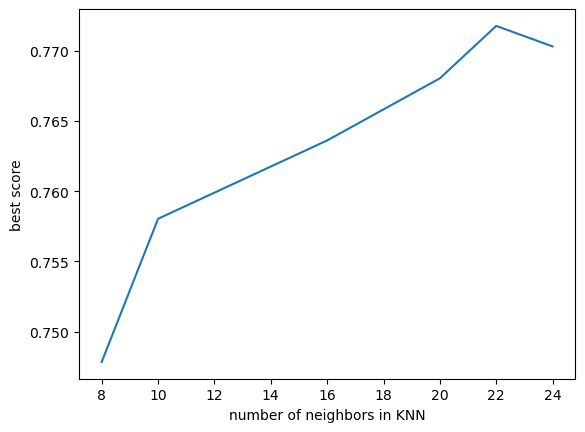

In [40]:
# model performance for different values of n_neghbors
results = pd.DataFrame(gs_cvec_knn.cv_results_)
results[results['mean_test_score'].notnull()].groupby('param_knn__n_neighbors').mean()['mean_test_score'].plot()
plt.xlabel('number of neighbors in KNN')
plt.ylabel('best score');

As we can see from the graph above, varying the number of neighbors above 8 does not impact the performance of the KNN estimator that much.

## Naive Bayes with CountVectorizer

In this part, we will use multinomial Naive Bayes estimator along with CountVectorizer to see if this model performs any better that the previous estimators.  

In [43]:
# create X train and test best on only the text column
Z_train = X_train['text']
Z_test = X_test['text']
# create a pipe instance 
pipe_cvec_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

# decide on what parameters to modify for transformer and estimator
params_cvec_mnb = {
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__max_df': [1.0, 0.8, 0.5],
    'cvec__min_df': [2, 4],
    'cvec__max_features': [3000, 5000],

}

gs_cvec_mnb = GridSearchCV(pipe_cvec_mnb,
                 param_grid=params_cvec_mnb,
                 n_jobs=-1,
                 cv=3,
                 verbose=1)

gs_cvec_mnb.fit(Z_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [1.0, 0.8, 0.5],
                         'cvec__max_features': [3000, 5000],
                         'cvec__min_df': [2, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english']},
             verbose=1)

In [44]:
print('============= MN Naive Bayes =============')
print(f'best cv score: {gs_cvec_mnb.best_score_}') # through cross-validation
print('=============')
print(f'best params:') # best parameters
[print(f'{ind}: {val}') for ind, val in gs_cvec_mnb.best_params_.items()];
print('=============')
pred = gs_cvec_mnb.predict(Z_test)

print(f'train score: {gs_cvec_mnb.score(Z_train, y_train)}')
print(f'test score: {gs_cvec_mnb.score(Z_test, y_test)}')

print('=============')
pd.DataFrame(gs_cvec_mnb.cv_results_).sort_values(by='mean_test_score', ascending=False).head(10)

============= MN Naive Bayes =============
best cv score: 0.8618542435424353
best params:
cvec__max_df: 0.8
cvec__max_features: 5000
cvec__min_df: 4
cvec__ngram_range: (1, 1)
cvec__stop_words: None
train score: 0.8716174661746617
test score: 0.8555179833999386


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_cvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
28,6.297384,0.188609,3.833857,0.056644,0.8,5000,4,"(1, 1)",None,"{'cvec__max_df': 0.8, 'cvec__max_features': 50...",0.856089,0.863007,0.866467,0.861854,0.004315,1
24,6.312376,0.079441,3.707902,0.057494,0.8,5000,2,"(1, 1)",None,"{'cvec__max_df': 0.8, 'cvec__max_features': 50...",0.854935,0.862085,0.865083,0.860701,0.004257,2
8,6.178606,0.451447,2.943527,0.144641,1.0,5000,2,"(1, 1)",None,"{'cvec__max_df': 1.0, 'cvec__max_features': 50...",0.853090,0.862315,0.866467,0.860624,0.005590,3
12,6.246121,0.131514,3.184285,0.208740,1.0,5000,4,"(1, 1)",None,"{'cvec__max_df': 1.0, 'cvec__max_features': 50...",0.852860,0.861854,0.866697,0.860470,0.005733,4
44,7.608717,0.282308,4.609104,0.262487,0.5,5000,4,"(1, 1)",None,"{'cvec__max_df': 0.5, 'cvec__max_features': 50...",0.855166,0.861854,0.862085,0.859702,0.003209,5
40,7.386199,0.187670,4.561079,0.221858,0.5,5000,2,"(1, 1)",None,"{'cvec__max_df': 0.5, 'cvec__max_features': 50...",0.854474,0.860932,0.862085,0.859164,0.003349,6
36,7.141134,0.243498,4.576399,0.539678,0.5,3000,4,"(1, 1)",None,"{'cvec__max_df': 0.5, 'cvec__max_features': 30...",0.853090,0.861624,0.861854,0.858856,0.004078,7
32,6.751924,0.131775,4.394756,0.234275,0.5,3000,2,"(1, 1)",None,"{'cvec__max_df': 0.5, 'cvec__max_features': 30...",0.853090,0.861624,0.861854,0.858856,0.004078,7
16,5.659574,0.112614,3.244684,0.227262,0.8,3000,2,"(1, 1)",None,"{'cvec__max_df': 0.8, 'cvec__max_features': 30...",0.852860,0.857472,0.863930,0.858087,0.004540,9
20,5.791603,0.157152,3.427759,0.198104,0.8,3000,4,"(1, 1)",None,"{'cvec__max_df': 0.8, 'cvec__max_features': 30...",0.853090,0.856780,0.863699,0.857857,0.004397,10


**Observations:**
- Similar to what we have observed with the previous models, it looks like whenever we increase the max features above a certain threshold, the model starts overfitting the data without that much of improvement in performance against the test/cv data. 
- In this case, 3000-5000 `max_features` gives us the best performance so we used this. 
- Bigrams and trigrams do not improve the estimator's performance. 
- Similarly, 'english' stopwords did not seem to help with the estimator's performance. 

## LogReg vs. KNN vs. Naive Bayes

The above mentioned models were used along with CountVectorizer in order to classify the subreddit listings in r/offmychest and r/relationship_advice subreddits. The following scores (accuracy score) were achieved for each of the estimator's best performance on test data:

| Estimator | Score |
| -------- | ------- |
| Logistic Regression  | 0.88   |
| KNN | 0.76     |
| Multinomial Naive Bayes| 0.85    |

Based on our observations, KNN showed the poorest performance. Logistic Regression and Naive Bayes show a comparable performance on the test dataset while Naive Bayes is faster. For the next part, we will use Naive Bayes and see how it performs with the `TfidfVectorizer` and `CountVectorizer` transformers.

## `tfidfVecotizer` vs. `CountVectorizer`

In the section, we will see how `TfidfVectorizer` performs against `CountVectorizer` when using Naive Bayes as our estimator. From the previous section, here is the best performance for the CountVectorizer transformer.

In [45]:
print('============= CountVectorizer with MN Naive Bayes =============')
print(f'best cv score: {gs_cvec_mnb.best_score_}') # through cross-validation
pred = gs_cvec_mnb.predict(Z_test)
print(f'train score: {gs_cvec_mnb.score(Z_train, y_train)}')
print(f'test score: {gs_cvec_mnb.score(Z_test, y_test)}')


============= CountVectorizer with MN Naive Bayes =============
best cv score: 0.8618542435424353
train score: 0.8716174661746617
test score: 0.8555179833999386


Now, let us repeat the same calculations with TfidfVectorizer.

In [46]:
# create X train and test best on only the text column
Z_train = X_train['text']
Z_test = X_test['text']
# create a pipe instance 
pipe_tfidf_mnb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

# decide on what parameters to modify for transformer and estimator
params_tfidf_mnb = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [1.0, 0.8, 0.5],
    'tfidf__min_df': [2, 4],
    'tfidf__max_features': [3000, 5000],
    'tfidf__norm': ['l1', 'l2', None], # 'l1', 

}

gs_tfidf_mnb = GridSearchCV(pipe_tfidf_mnb,
                 param_grid=params_tfidf_mnb,
                 n_jobs=-1,
                 cv=3,
                 verbose=1)

gs_tfidf_mnb.fit(Z_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tfidf__max_df': [1.0, 0.8, 0.5],
                         'tfidf__max_features': [3000, 5000],
                         'tfidf__min_df': [2, 4],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__norm': ['l1', 'l2', None],
                         'tfidf__stop_words': [None, 'english']},
             verbose=1)

In [47]:
print('============= TfidfVectorizer with Naive Bayes =============')
print(f'best cv score: {gs_tfidf_mnb.best_score_}') # through cross-validation
print('=============')
print(f'best params:') # best parameters
[print(f'{ind}: {val}') for ind, val in gs_tfidf_mnb.best_params_.items()];
print('=============')
pred = gs_tfidf_mnb.predict(Z_test)

print(f'train score: {gs_tfidf_mnb.score(Z_train, y_train)}')
print(f'test score: {gs_tfidf_mnb.score(Z_test, y_test)}')

print('=============')
pd.DataFrame(gs_tfidf_mnb.cv_results_).sort_values(by='mean_test_score', ascending=False).head(10)

============= TfidfVectorizer with Naive Bayes =============
best cv score: 0.862238622386224
best params:
tfidf__max_df: 0.8
tfidf__max_features: 5000
tfidf__min_df: 4
tfidf__ngram_range: (1, 1)
tfidf__norm: None
tfidf__stop_words: None
train score: 0.878459409594096
test score: 0.8524438979403628


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__max_df,param_tfidf__max_features,param_tfidf__min_df,param_tfidf__ngram_range,param_tfidf__norm,param_tfidf__stop_words,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
88,10.256163,1.078352,6.066869,0.232136,0.8,5000,4,"(1, 1)",None,None,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.858856,0.864622,0.863238,0.862239,0.002458,1
76,11.055575,0.619728,5.970418,0.321915,0.8,5000,2,"(1, 1)",None,None,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.857472,0.864391,0.862546,0.861470,0.002925,2
28,6.574344,0.413404,3.397216,0.108963,1.0,5000,2,"(1, 1)",None,None,"{'tfidf__max_df': 1.0, 'tfidf__max_features': ...",0.857011,0.863699,0.863469,0.861393,0.003100,3
40,7.181171,0.345824,3.695327,0.050785,1.0,5000,4,"(1, 1)",None,None,"{'tfidf__max_df': 1.0, 'tfidf__max_features': ...",0.857011,0.862777,0.863469,0.861085,0.002895,4
64,9.920509,0.379328,5.693457,0.382634,0.8,3000,4,"(1, 1)",None,None,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.857934,0.862777,0.862546,0.861085,0.002231,4
16,7.252201,0.782800,4.045300,0.319857,1.0,3000,4,"(1, 1)",None,None,"{'tfidf__max_df': 1.0, 'tfidf__max_features': ...",0.858164,0.862777,0.862315,0.861085,0.002074,4
52,8.012227,0.212582,4.860599,0.325511,0.8,3000,2,"(1, 1)",None,None,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.857934,0.862777,0.862315,0.861009,0.002183,7
4,5.454781,0.160350,2.699809,0.059134,1.0,3000,2,"(1, 1)",None,None,"{'tfidf__max_df': 1.0, 'tfidf__max_features': ...",0.857472,0.862777,0.862315,0.860855,0.002399,8
82,29.422152,2.037504,12.581493,0.726590,0.8,5000,2,"(1, 2)",None,None,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.855166,0.857934,0.860009,0.857703,0.001984,9
142,18.287188,0.459608,6.588117,0.759390,0.5,5000,4,"(1, 2)",None,None,"{'tfidf__max_df': 0.5, 'tfidf__max_features': ...",0.854474,0.860240,0.858164,0.857626,0.002384,10


Comparing the estimators performance for `TfidfVectorizer` and `CountVectorizer`, we can see both transformers have similar performances when used along with the Naive Bayes and no one outperformed the other. 

## Using both text and numerical features

In this part, we will try to use both text data and also the numerical features we extracted previously from the listings (the length of the columns and the sentiment of listings) to see if our estimator can do any better. To do this, we will have to create a column transfer operator that performs different operations on different columns and then use that in a pipeline with our logistic regression estimator (more on this here: https://stackoverflow.com/questions/63467815/how-to-access-columntransformer-elements-in-gridsearchcv). <br>
The reason we use logistic regression is the fact that we will have numeric data that are not necessarily integers and although Naive Bayes library in sklearn works with none-integer data, in the documentation it has stated otherwise.  


In [48]:
X_train.head(3)

,text,word_count,sentiment
3444,"Forgive my format and spelling, I’m quite upse...",398,-0.2011
9517,Im running out of ideas. I myself am also a de...,269,-0.6616
3966,"First of all, English is not my first languag...",161,-0.4099


For the above three features, we will use CountVectorizer on the text column while using StandardScaler for the word_count and sentiment columns.

In [49]:
# create X train and test best on only the text column
Z_train = X_train.copy()
Z_test = X_test.copy()

# create the column transformer
ctx = ColumnTransformer(transformers = 
                                 [('sc', StandardScaler(), ['word_count', 'sentiment']),
# make sure this is not in a list as countvectorizer doesnt work with dataframe and has to be one column
                                  ('cvec', CountVectorizer(), 'text')]) 

# create a pipe instance 
pipe_ctx_logr = Pipeline([('ctx', ctx),
                          ('logr', LogisticRegression())])

# decide on what parameters to modify for transformer and estimator
pipe_ctx_logr_params = {
    'ctx__cvec__stop_words': [None, 'english'],
    'ctx__cvec__ngram_range': [(1, 2)],
    'ctx__cvec__max_df': [1.0, 0.8, 0.5],
    'ctx__cvec__min_df': [2, 4],
    'ctx__cvec__max_features': [3000], #, 5000],

    'logr__C': [0.1, 0.5, 1],
    'logr__penalty': ['l2', None] #, None], #, 'elasticnet', 'none']
}

gs_ctx_logr = GridSearchCV(pipe_ctx_logr,
                  param_grid=pipe_ctx_logr_params,
                  n_jobs=-1,
                  cv=3,
                  verbose=3)

gs_ctx_logr.fit(Z_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\masou\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ctx',
                                        ColumnTransformer(transformers=[('sc',
                                                                         StandardScaler(),
                                                                         ['word_count',
                                                                          'sentiment']),
                                                                        ('cvec',
                                                                         CountVectorizer(),
                                                                         'text')])),
                                       ('logr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'ctx__cvec__max_df': [1.0, 0.8, 0.5],
                         'ctx__cvec__max_features': [3000],
                         'ctx__cvec__min_df': [2, 4],
                         'ctx__cvec__ngram_range': [(1, 2)],
                         'ctx__cvec__stop_words': [None, 'english'],
                         'logr__C': [0.1, 0.5, 1],
                         'logr__penalty': ['l2', None]},
             verbose=3)

In [50]:
print('============= LogReg with text and numerical features =============')
print(f'best cv score: {gs_ctx_logr.best_score_}') # through cross-validation
print('=============')
print(f'best params:') # best parameters
[print(f'{ind}: {val}') for ind, val in gs_ctx_logr.best_params_.items()];
print('=============')
pred = gs_ctx_logr.predict(Z_test)

print(f'train score: {gs_ctx_logr.score(Z_train, y_train)}')
print(f'test score: {gs_ctx_logr.score(Z_test, y_test)}')

print('=============')
pd.DataFrame(gs_ctx_logr.cv_results_).sort_values(by='mean_test_score', ascending=False).head(10)

============= LogReg with text and numerical features =============
best cv score: 0.8802275522755227
best params:
ctx__cvec__max_df: 0.5
ctx__cvec__max_features: 3000
ctx__cvec__min_df: 2
ctx__cvec__ngram_range: (1, 2)
ctx__cvec__stop_words: english
logr__C: 0.1
logr__penalty: l2
train score: 0.9545664206642066
test score: 0.8853366123578236


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ctx__cvec__max_df,param_ctx__cvec__max_features,param_ctx__cvec__min_df,param_ctx__cvec__ngram_range,param_ctx__cvec__stop_words,param_logr__C,param_logr__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
54,16.177509,0.480519,5.189768,0.334046,0.5,3000,2,"(1, 2)",english,0.1,l2,"{'ctx__cvec__max_df': 0.5, 'ctx__cvec__max_fea...",0.881919,0.881688,0.877076,0.880228,0.002231,1
66,16.419201,1.741717,4.211856,0.165992,0.5,3000,4,"(1, 2)",english,0.1,l2,"{'ctx__cvec__max_df': 0.5, 'ctx__cvec__max_fea...",0.881458,0.881227,0.876614,0.879766,0.002231,2
30,17.699712,0.562648,4.780618,0.745841,0.8,3000,2,"(1, 2)",english,0.1,l2,"{'ctx__cvec__max_df': 0.8, 'ctx__cvec__max_fea...",0.880996,0.880766,0.876153,0.879305,0.002231,3
6,14.997164,0.257010,4.405334,0.133628,1.0,3000,2,"(1, 2)",english,0.1,l2,"{'ctx__cvec__max_df': 1.0, 'ctx__cvec__max_fea...",0.880996,0.880766,0.876153,0.879305,0.002231,3
18,15.619483,0.809818,4.887965,0.555054,1.0,3000,4,"(1, 2)",english,0.1,l2,"{'ctx__cvec__max_df': 1.0, 'ctx__cvec__max_fea...",0.880535,0.880996,0.874769,0.878767,0.002833,5
42,16.305979,0.334450,4.907816,0.311614,0.8,3000,4,"(1, 2)",english,0.1,l2,"{'ctx__cvec__max_df': 0.8, 'ctx__cvec__max_fea...",0.880535,0.880996,0.874769,0.878767,0.002833,5
8,14.798360,0.078190,4.485559,0.106355,1.0,3000,2,"(1, 2)",english,0.5,l2,"{'ctx__cvec__max_df': 1.0, 'ctx__cvec__max_fea...",0.873616,0.873847,0.865775,0.871079,0.003752,7
32,15.304871,0.470835,3.879043,0.377604,0.8,3000,2,"(1, 2)",english,0.5,l2,"{'ctx__cvec__max_df': 0.8, 'ctx__cvec__max_fea...",0.873616,0.873847,0.865775,0.871079,0.003752,7
20,16.428017,1.236218,4.539620,0.390428,1.0,3000,4,"(1, 2)",english,0.5,l2,"{'ctx__cvec__max_df': 1.0, 'ctx__cvec__max_fea...",0.874308,0.873616,0.864161,0.870695,0.004629,9
44,15.625378,0.465499,4.205058,0.084745,0.8,3000,4,"(1, 2)",english,0.5,l2,"{'ctx__cvec__max_df': 0.8, 'ctx__cvec__max_fea...",0.874308,0.873616,0.864161,0.870695,0.004629,9


Looking at these results, we can see that using the numerical features (sentiment score and word counts) does not seem to improve the performance of our model. Additionally, the model still suffers from having a relatively high variance.

## Random forest with CountVectorizer

As the last part in our model tuning and comparison notebook, we will create a pipline to evaluate whether ensemble based models like random forest could perform well in our problem of classifying two subreddits (offmychest and relationship_advice). 

In [51]:
# create X train and test best on only the text column
Z_train = X_train['text']
Z_test = X_test['text']
# create a pipe instance 
pipe_cvec_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

# decide on what parameters to modify for transformer and estimator
params_cvec_rf = {
    'cvec__stop_words': ['english'],
    'cvec__ngram_range': [(1, 2)],
    'cvec__max_df': [1.0, 0.8],
    'cvec__min_df': [2],
    'cvec__max_features': [1000, 3000],

    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 10, 100, 500],
    'rf__random_state' : [42],
    'rf__min_samples_split': [2, 8, 20],
    'rf__min_samples_leaf': [1, 5, 10]

}

gs_cvec_rf = RandomizedSearchCV(pipe_cvec_rf,
                 param_distributions=params_cvec_rf,
                 n_jobs=-1,
                 cv=3,
                 n_iter=150,
                 random_state=42,
                 verbose=1)

gs_cvec_rf.fit(Z_train, y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'cvec__max_df': [1.0, 0.8],
                                        'cvec__max_features': [1000, 3000],
                                        'cvec__min_df': [2],
                                        'cvec__ngram_range': [(1, 2)],
                                        'cvec__stop_words': ['english'],
                                        'rf__max_depth': [None, 10, 100, 500],
                                        'rf__min_samples_leaf': [1, 5, 10],
                                        'rf__min_samples_split': [2, 8, 20],
                                        'rf__n_estimators': [100, 150, 200],
                                        'rf__random_state': [42]},
                   random_state=42, verbose=1)

In [52]:
print('============= LogReg with text and numerical features =============')
print(f'best cv score: {gs_cvec_rf.best_score_}') # through cross-validation
print('=============')
print(f'best params:') # best parameters
[print(f'{ind}: {val}') for ind, val in gs_cvec_rf.best_params_.items()];
print('=============')
pred = gs_cvec_rf.predict(Z_test)

print(f'train score: {gs_cvec_rf.score(Z_train, y_train)}')
print(f'test score: {gs_cvec_rf.score(Z_test, y_test)}')

print('=============')
pd.DataFrame(gs_cvec_rf.cv_results_).sort_values(by='mean_test_score', ascending=False).head(10)

============= LogReg with text and numerical features =============
best cv score: 0.843019680196802
best params:
rf__random_state: 42
rf__n_estimators: 200
rf__min_samples_split: 8
rf__min_samples_leaf: 1
rf__max_depth: None
cvec__stop_words: english
cvec__ngram_range: (1, 2)
cvec__min_df: 2
cvec__max_features: 3000
cvec__max_df: 1.0
train score: 0.9980781057810578
test score: 0.839840147556102


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__random_state,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_depth,param_cvec__stop_words,...,param_cvec__min_df,param_cvec__max_features,param_cvec__max_df,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
79,109.685304,1.084800,4.953828,0.049119,42,200,8,1,None,english,...,2,3000,1.0,"{'rf__random_state': 42, 'rf__n_estimators': 2...",0.842712,0.848017,0.838330,0.843020,0.003960,1
137,80.202850,2.515066,4.801436,0.112694,42,200,8,1,500,english,...,2,3000,1.0,"{'rf__random_state': 42, 'rf__n_estimators': 2...",0.842712,0.848017,0.838330,0.843020,0.003960,1
16,61.789788,0.729063,4.742171,0.026716,42,150,8,1,100,english,...,2,3000,0.8,"{'rf__random_state': 42, 'rf__n_estimators': 1...",0.839945,0.847325,0.839714,0.842328,0.003535,3
138,63.562473,2.060702,4.720236,0.088202,42,150,8,1,500,english,...,2,3000,0.8,"{'rf__random_state': 42, 'rf__n_estimators': 1...",0.839945,0.847094,0.839022,0.842020,0.003607,4
115,92.649003,2.624225,4.874978,0.079650,42,200,2,1,None,english,...,2,3000,1.0,"{'rf__random_state': 42, 'rf__n_estimators': 2...",0.838561,0.845710,0.841098,0.841790,0.002959,5
95,59.334175,5.718600,5.265125,0.401963,42,100,2,1,100,english,...,2,3000,0.8,"{'rf__random_state': 42, 'rf__n_estimators': 1...",0.839483,0.848939,0.836255,0.841559,0.005382,6
49,79.132396,3.328398,5.397956,0.621120,42,150,2,1,100,english,...,2,3000,0.8,"{'rf__random_state': 42, 'rf__n_estimators': 1...",0.838330,0.846633,0.839253,0.841405,0.003716,7
45,75.601540,2.526679,5.226127,0.221122,42,200,20,1,None,english,...,2,3000,1.0,"{'rf__random_state': 42, 'rf__n_estimators': 2...",0.840637,0.842482,0.840406,0.841175,0.000929,8
126,52.724481,1.523043,4.782631,0.123964,42,100,2,1,None,english,...,2,3000,1.0,"{'rf__random_state': 42, 'rf__n_estimators': 1...",0.839483,0.847094,0.836255,0.840944,0.004544,9
24,72.875043,2.073955,4.612156,0.057167,42,150,2,1,None,english,...,2,3000,0.8,"{'rf__random_state': 42, 'rf__n_estimators': 1...",0.836946,0.847094,0.836716,0.840252,0.004839,10


As we can see from the results, the performance of our ensemble based model is worse than the logistic regression and Naive Bayes. Also, although we have used ensemble of models, the random forest model shows almost a perfect fit to the training data while the test data does not show that much of a good results, which is an indication of overfitting. 

## Key takeaways

In this notebook, we investigated the performance of different estimators and transformers in classifying subreddits. Here are some of the key observations:
- Logistic Regression and Naive Bayes models show similar performance while the latter runs faster, and both of them perform better than KNN classifier. 
- Using too many words (more than 3000 words) in classifying the documents seem not to help too much in our test score while contributing significantly to model variance and overfitting. 
- Both `TfidfVectorizer` and `CountVectorizer` provide similar performance with our estimators and there is no observer advantages over using any specific transformer. 
- There is no observed advantage of using extra information like sentiment scores and words counts for categorizing the listings from different subreddits.
- Ensemble tree-based models like random forest tend to extremely overfit the data while the performance on the test data is not as good as logistic regression or Naive Bayes models. 